In [23]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


# Parametros de la grilla

In [46]:
Lx, Ly = 28, 28
grid_size = (Lx, Ly)

# Carga de datos


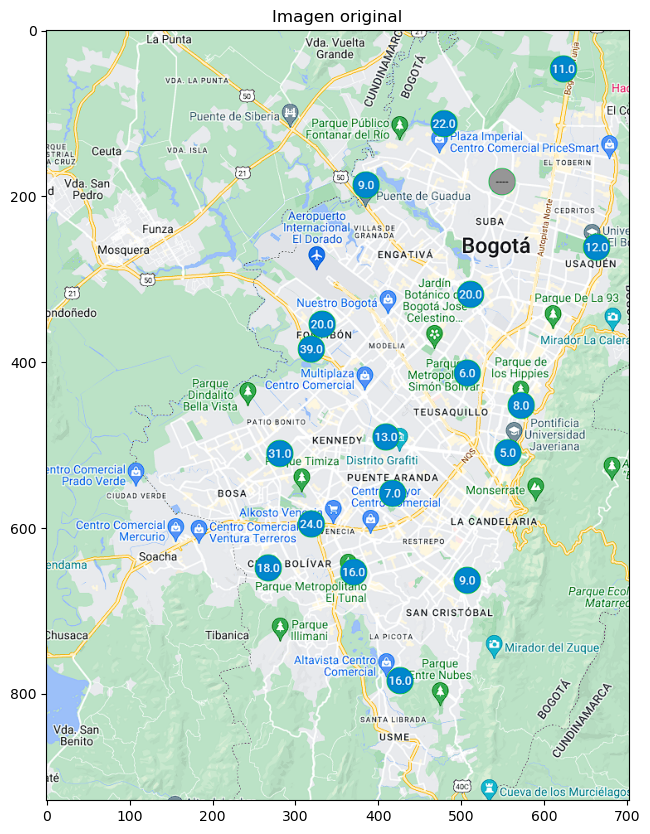

In [47]:
image_path = '../Map1.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

# Lectura de la imagen

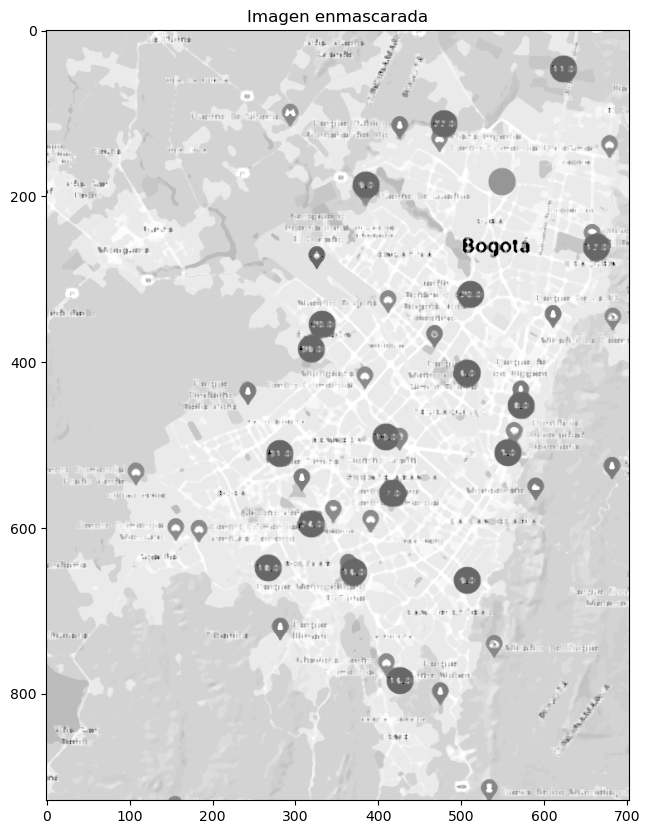

In [48]:

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar suavizado para mejorar la detección de círculos
image_blur = cv2.medianBlur(image_gray, 5)

# Definir el rango de valores de gris oscuro
lower_gray = 100
upper_gray = 255

# Crear una máscara para los píxeles oscuros
mask = cv2.inRange(image_blur, lower_gray, upper_gray)

# Aplicar la máscara a la imagen borrosa
masked_image = cv2.bitwise_and(image_blur, image_blur, mask=mask)

# Mostrar la imagen enmascarada
plt.figure(figsize=(10, 10))
plt.imshow(masked_image, cmap='gray')
plt.title('Imagen enmascarada')
plt.show()



# Identificación de coordenadas en la grilla

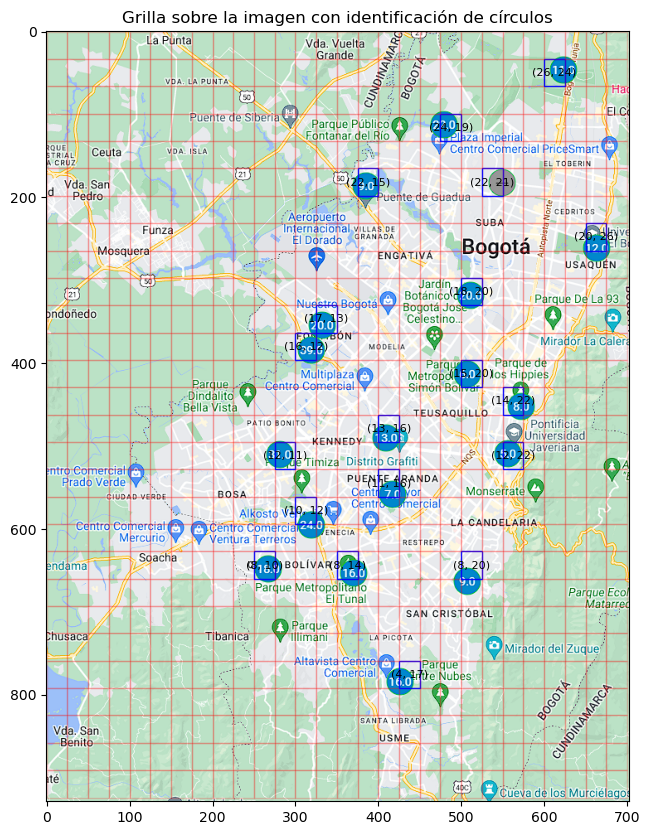

Numero de estaciones contadas: 19.0


In [49]:
# Detectar círculos usando la transformada de Hough
circles = cv2.HoughCircles(masked_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                           param1=50, param2=30, minRadius=15, maxRadius=25)


# Verificar si se han detectado círculos
if circles is not None:
    # Redondear las coordenadas y el radio de los círculos
    circles = np.round(circles[0, :]).astype("int")
    # Crear una matriz para almacenar la grilla de posiciones de las estaciones
    height, width, _ = image.shape
    #Se definen las dimensiones de las celdas
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]
    #Se crea la matriz de posiciones de las estaciones
    stations_positions = np.zeros(grid_size)

    # Crear una figura para visualizar la imagen y la grilla
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    N_estaciones = 0

    # Procesar cada círculo detectado
    for (x, y, r) in circles:
        #Celda en la que se encuentra el círculo
        cell_x = x // cell_width
        cell_y = ((height - y)  // cell_height) 
        #Obs: Mirar rodeando la celda
        
        # Marcar la celda en la grilla
        stations_positions[cell_y, cell_x] = 1

    # Colorear la grilla sobre la imagen
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if stations_positions[i, j] == 1:
                N_estaciones +=  stations_positions[i, j]
                rect = patches.Rectangle((j * cell_width, (Lx - 1 - i) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='b', facecolor='none', alpha=0.9)
                ax.add_patch(rect)
                # Anotar la posición en la celda
                plt.text(j * cell_width + cell_width / 2, (Lx - 1 - i) * cell_height + cell_height / 2, f'({i}, {j})', color='black', fontsize=8, ha='center', va='center', alpha=1)
                
            else:
                rect = patches.Rectangle((j * cell_width, (Lx - 1 - i) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='r', facecolor='none', alpha=0.2)
                ax.add_patch(rect)

    # Mostrar la imagen con las posiciones de los círculos y la grilla coloreada
    plt.title('Grilla sobre la imagen con identificación de círculos')
    plt.show()
    print(f'Numero de estaciones contadas: {N_estaciones}')

else:
    print("No se detectaron círculos.")

# Relacionación con las estaciones reales

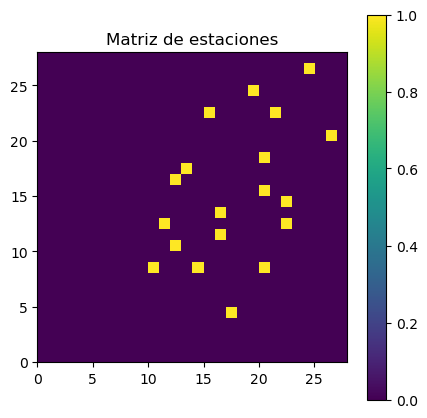

In [50]:
#Matiz de estaciones
plt.figure(figsize=(5,5))
plt.imshow(stations_positions, extent=[0, Lx, 0, Ly], origin='lower')
plt.colorbar()
plt.title('Matriz de estaciones')
plt.show()

In [51]:
#Lectura de estaciones
data_estaciones = pd.read_csv('../estaciones.txt')
data_estaciones

,Estación,VelViento,DirViento,PM10,Pm2.5
0,Guaymaral,True,True,True,True
1,Suba,True,True,True,True
2,Colina,True,True,True,True
3,Bolivia,False,False,False,True
4,Usaquén,True,True,True,True
5,Las Ferias,True,True,True,True
6,Fontibón,True,True,True,True
7,Estación Movil Fontibón,False,False,True,True
8,Centro de Alto Rendimiento,True,True,True,True
9,Móvil Séptima,True,True,True,True


In [52]:
# Inicializar listas para las coordenadas X e Y
coords_X = []
coords_Y = []


# Verificar si lo siguiente es correcto
# Recorrer `stations_positions` y asignar coordenadas a los valores distintos de cero
# Estas se recorren en i de izquierda a derecha y en j de abajo hacia arriba ya
# en el dataset se encuentran las estaciones en orden de arriba hacia abajo y 
# de izquierda a derecha
for i in reversed(range(Lx)):
    for j in reversed(range(Ly)):
        if stations_positions[i, j] != 0:
            # print(f'Estación en la celda ({i}, {j})')
            coords_X.append(i)
            coords_Y.append(j)

# Asignar las coordenadas al DataFrame
data_estaciones['x_cell'] = coords_X
data_estaciones['y_cell'] = coords_Y

data_estaciones

,Estación,VelViento,DirViento,PM10,Pm2.5,x_cell,y_cell
0,Guaymaral,True,True,True,True,26,24
1,Suba,True,True,True,True,24,19
2,Colina,True,True,True,True,22,21
3,Bolivia,False,False,False,True,22,15
4,Usaquén,True,True,True,True,20,26
5,Las Ferias,True,True,True,True,18,20
6,Fontibón,True,True,True,True,17,13
7,Estación Movil Fontibón,False,False,True,True,16,12
8,Centro de Alto Rendimiento,True,True,True,True,15,20
9,Móvil Séptima,True,True,True,True,14,22


In [45]:
#Observaciones codigo:
# Mostrar incendios
# Poner distancias en la imagen
# Tener cuidad con el tamaño de las celdas y el tamaño de los circulos